In [1]:
!pip install pmdarima 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.3 MB/s eta 0:00:0000:0100:01


In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
from pmdarima.arima import auto_arima
rcParams['figure.figsize'] = 12, 10

In [3]:
df = pd.read_csv('/kaggle/input/time-series-datasets/Electric_Production.csv')
df['DATE'] = pd.to_datetime(df['DATE'],infer_datetime_format=True)
df = df.set_index(['DATE'])

In [4]:
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [5]:
x = int(0.80 * len(df))
x

317

In [6]:
train = df[:x]
test = df[x:]
train, test

(            IPG2211A2N
 DATE                  
 1985-01-01     72.5052
 1985-02-01     70.6720
 1985-03-01     62.4502
 1985-04-01     57.4714
 1985-05-01     55.3151
 ...                ...
 2011-01-01    119.4880
 2011-02-01    107.3753
 2011-03-01     99.1028
 2011-04-01     89.3583
 2011-05-01     90.0698
 
 [317 rows x 1 columns],
             IPG2211A2N
 DATE                  
 2011-06-01    102.8204
 2011-07-01    114.7068
 2011-08-01    113.5958
 2011-09-01     99.4712
 2011-10-01     90.3566
 ...                ...
 2017-09-01     98.6154
 2017-10-01     93.6137
 2017-11-01     97.3359
 2017-12-01    114.7212
 2018-01-01    129.4048
 
 [80 rows x 1 columns])

In [7]:
class ModelARIMA:
    def __init__(self):
        self.df = None
        return 
    
    def load_timeseries(self, series: pd.DataFrame):
        self.df = series
    
    def plot_series(self):
        plt.xlabel(df.index.name)
        plt.ylabel(df.columns[0])
        plt.plot(self.df)
        plt.title('Series plot')
    
    def plot_rolling_stats(self, rolling_window: int):
        rolmean = self.df.rolling(window=rolling_window).mean()
        rolstd = self.df.rolling(window=rolling_window).std()
        orig = plt.plot(self.df, color='blue', label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show(block=False)
    
    def test_stationarity(self):
        print('Results of Dickey Fuller Test:')
        dftest = adfuller(self.df[self.df.columns[0]], autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)
    
    def acf_differencing_plots(self, max_order):
        fig, axes = plt.subplots(max_order+1, 3)
        axes[0, 0].plot(self.df); axes[0, 0].set_title('Original Series')
        plot_acf(self.df, ax=axes[0, 1])
        plot_pacf(self.df, ax=axes[0, 2])

        for order in range(1, max_order+1):
            axes[order, 0].plot(self.df.diff(order)); axes[order, 0].set_title(str(order)+' Order Differencing')
            plot_acf(self.df.diff(order).dropna(), ax=axes[order, 1])
            plot_pacf(self.df.diff(order).dropna(), ax=axes[order, 2])

        plt.tight_layout()
    
    def ets_decomposition_plot(self, plot = 'all'):
        if plot == 'all':
            seasonal_decompose(self.df[self.df.columns[0]], model = 'multiplicative').plot()
        elif plot == 'seasonal':
            seasonal_decompose(self.df[self.df.columns[0]], model = 'multiplicative').seasonal.plot()
        elif plot == 'error':
            seasonal_decompose(self.df[self.df.columns[0]], model = 'multiplicative').resid.plot()
        elif plot == 'trend':
            seasonal_decompose(self.df[self.df.columns[0]], model = 'multiplicative').trend.plot()
        else:
            print('Incorrect value \''+ plot + '\' for \'plot\'')

    def build_model(self, order = None, show_summary = True):
        if order is None:
            self.auto = True
            model = auto_arima(self.df, start_p=1, start_q=1,
                      test='adf',       
                      max_p=5, max_q=5, 
                      m=1,             
                      d=None,           
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
            self.model_fit = model
            if show_summary:
                print(model.summary())
        else:
            self.auto = False
            model = ARIMA(self.df, order=order)
            model_fit = model.fit()
            if show_summary:
                print(model_fit.summary())
            self.model_fit = model_fit
            print('Model built successfully.')
    
    def plot_forecast(self, periods):
        if not self.auto:
            fig = plt.figure()
            self.df.plot(label = 'Series')
            fc = self.model_fit.forecast(periods)
            fc.plot(label = 'Forecast')
        else:
            fig = plt.figure()
            df.plot(label = 'Series')
            fc = self.model_fit.predict(periods)
            fc.plot(label = 'Forecast')
    
    def get_forecasts(self, periods):
        if not self.auto:
            return self.model_fit.forecast(periods)
        else:
            return self.model_fit.predict(periods)
    
    def error_metrics(self, test_series):
        actual = test_series[test_series.columns[0]].to_numpy()
        forecast = self.get_forecasts(len(actual)).values
#         print(forecast.shape, actual.shape)
        mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  
        me = np.mean(forecast - actual)             
        mae = np.mean(np.abs(forecast - actual)) 
        mpe = np.mean((forecast - actual)/actual) 
        rmse = np.mean((forecast - actual)**2)**.5  
        corr = np.corrcoef(forecast, actual)[0,1]   
        mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
        maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
        minmax = 1 - np.mean(mins/maxs)             
#         acf1 = acf(fc-test)[1]
        return (pd.Series({'mape':mape, 'me':me, 'mae': mae, 
                'mpe': mpe, 'rmse':rmse, 'minmax':minmax}))

    def plot_test_forecast(self, test_series):
        if not self.auto:
            ax = self.df.plot()
            test_series.plot(ax = ax, color = 'g')
            fc = self.model_fit.forecast(len(test_series))
            fc.plot(ax = ax, color = 'r')
            plt.show()
        else:
            ax = df.plot(label = 'Series')
            test_series.plot(ax = ax, color = 'g')
            fc = self.model_fit.predict(len(test_series))
            fc.plot(ax = ax, color = 'r')
            plt.show()

In [8]:
arima = ModelARIMA()
arima.load_timeseries(train)

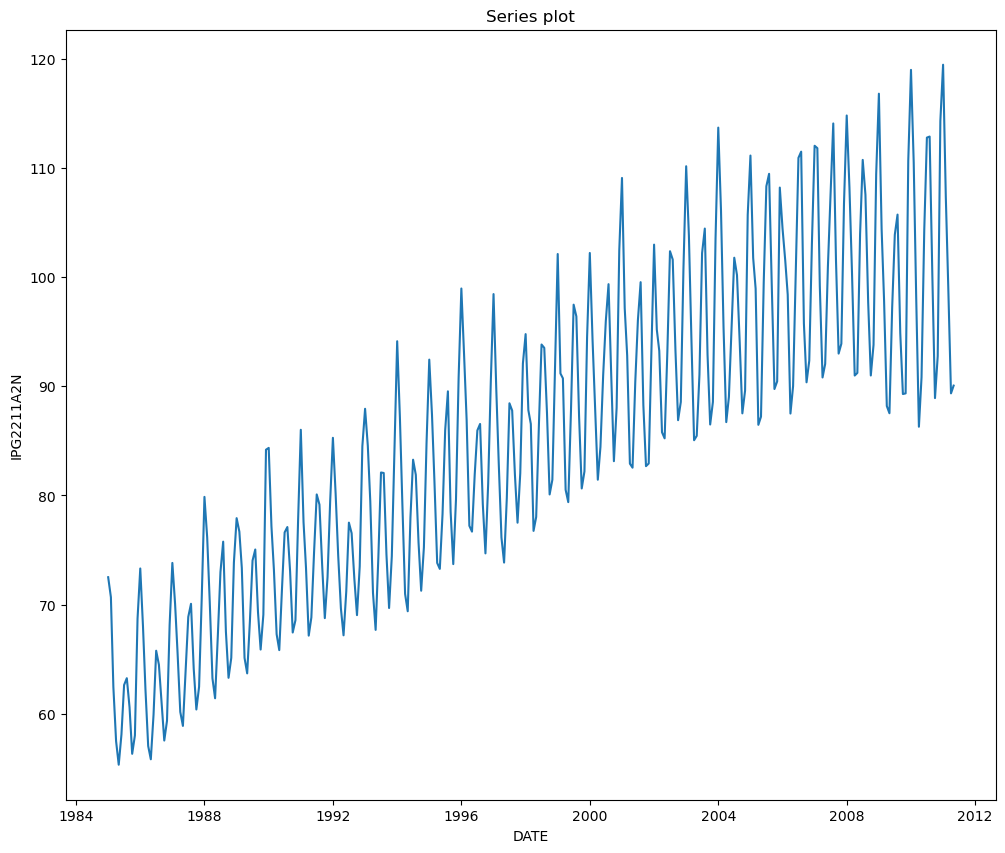

In [9]:
arima.plot_series()

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


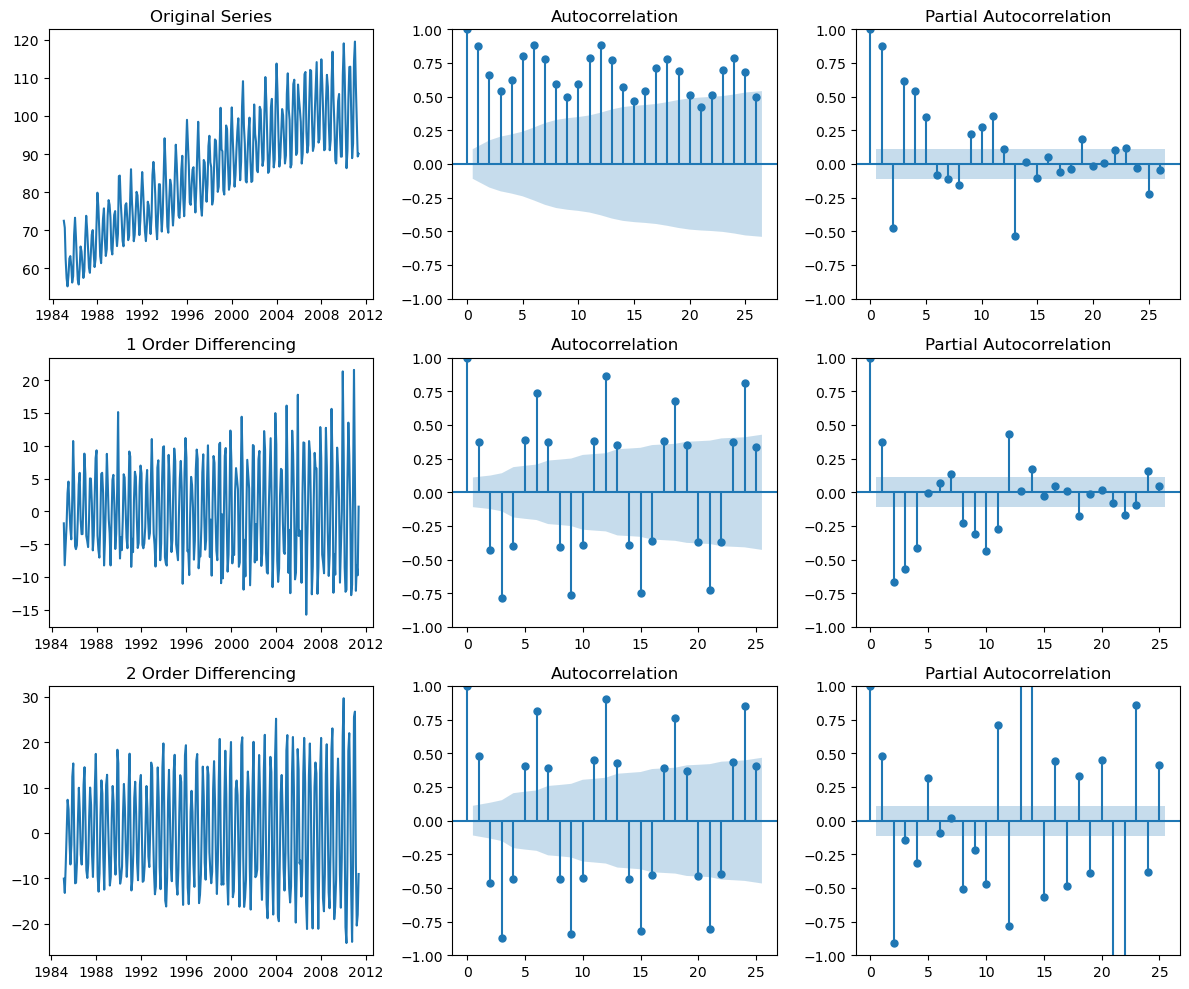

In [10]:
arima.acf_differencing_plots(2)

In [11]:
arima.build_model()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2062.325, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3729.918, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3315.986, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2063.950, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1995.215, Time=0.27 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1968.715, Time=0.22 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1939.254, Time=0.73 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1938.985, Time=0.50 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2684.884, Time=1.05 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=1921.975, Time=0.86 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=2503.246, Time=0.83 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=1892.5

In [12]:
arima.error_metrics(test)

mape      0.062640
me       -6.398467
mae       6.534217
mpe      -0.061293
rmse      7.821498
minmax    0.062630
dtype: float64

In [13]:
arima.get_forecasts(100)

2011-06-01    102.964316
2011-07-01    109.758123
2011-08-01    105.726621
2011-09-01     91.984463
2011-10-01     85.186656
                 ...    
2019-05-01     88.284658
2019-06-01     99.493167
2019-07-01    105.823256
2019-08-01    100.494001
2019-09-01     88.784046
Freq: MS, Length: 100, dtype: float64

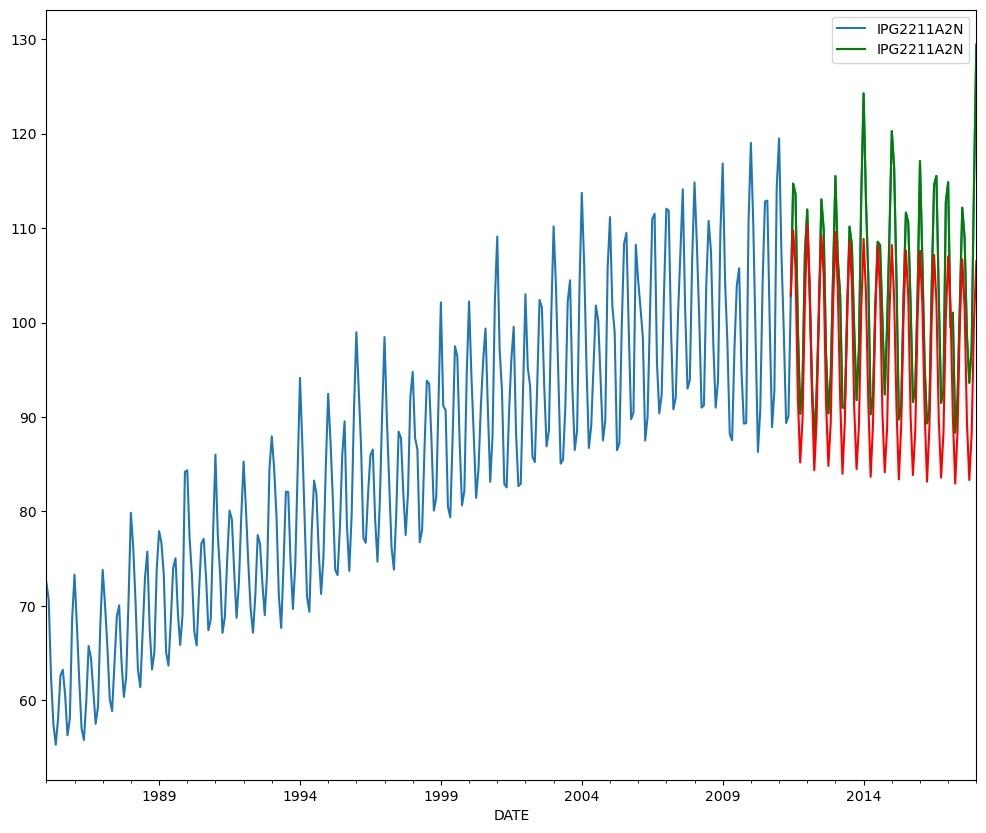

In [14]:
arima.plot_test_forecast(test)